In [65]:
import src.service.get_data as av
import src.model.SplitData as sd
import src.model.WindowGenerator as wg
from src.model.WindowGenerator import WindowGenerator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [66]:
API_KEY = "trail"
alpha_vantage = av.AlphaVantageAPI(API_KEY)
df = alpha_vantage.get_weekly_stock_prices("AAPL")

In [67]:
split_data = sd.SplitData(df)
split_data.train_df

,open,high,low,close,volume
1999-11-12,-0.474965,-0.436200,-0.461892,-0.459610,-0.387640
1999-11-19,-0.463953,-0.453300,-0.454010,-0.448911,-0.440461
1999-11-26,-0.451410,-0.448997,-0.451363,-0.433509,-0.457769
1999-12-03,-0.436689,-0.333886,-0.422784,-0.316291,-0.377702
1999-12-10,-0.317089,-0.319884,-0.388188,-0.386833,-0.390369
...,...,...,...,...,...
2017-06-16,-0.133478,-0.150604,-0.128269,-0.155983,0.449826
2017-06-23,-0.145727,-0.152555,-0.119484,-0.132410,0.032564
2017-06-30,-0.125057,-0.146128,-0.127787,-0.145696,0.048118
2017-07-07,-0.138543,-0.163228,-0.127005,-0.144755,-0.163835


In [68]:
df.tail()

,open,high,low,close,volume
2025-01-24,224.00,227.03,219.38,222.78,277129596.0
2025-01-31,224.02,247.19,223.98,236.00,372790494.0
2025-02-07,229.99,234.00,225.70,227.63,227428164.0
2025-02-14,229.57,245.55,227.20,244.60,226587580.0
2025-02-21,244.15,248.69,241.84,245.55,166541044.0


In [69]:
window = wg.WindowGenerator(input_width=120, label_width=5, shift=1, split_data=split_data, label_columns=['close'])
window

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [116 117 118 119 120]
Label column name(s): ['close']

In [70]:
def split_window_static(window, features):
    inputs = features[:, window.input_slice, :]
    labels = features[:, window.labels_slice, :]
    if window.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, window.column_indices[name]] for name in window.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, window.input_width, None])
    labels.set_shape([None, window.label_width, None])

    return inputs, labels

In [75]:
# Stack three slices, the length of the total window.
example_window = tf.stack([
            np.array(split_data.train_df[:window.total_window_size]),
            np.array(split_data.train_df[100:100+window.total_window_size]),
            np.array(split_data.train_df[200:200+window.total_window_size])])

#example_inputs, example_labels = window.split_window(example_window)

window = WindowGenerator(input_width=120, label_width=5, shift=1, split_data=split_data, label_columns=['close'])
example_inputs, example_labels = split_window_static(window, example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 121, 5)
Inputs shape: (3, 120, 5)
Labels shape: (3, 5, 1)


In [76]:

window.example = example_inputs, example_labels

In [77]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [week]')

WindowGenerator.plot = plot

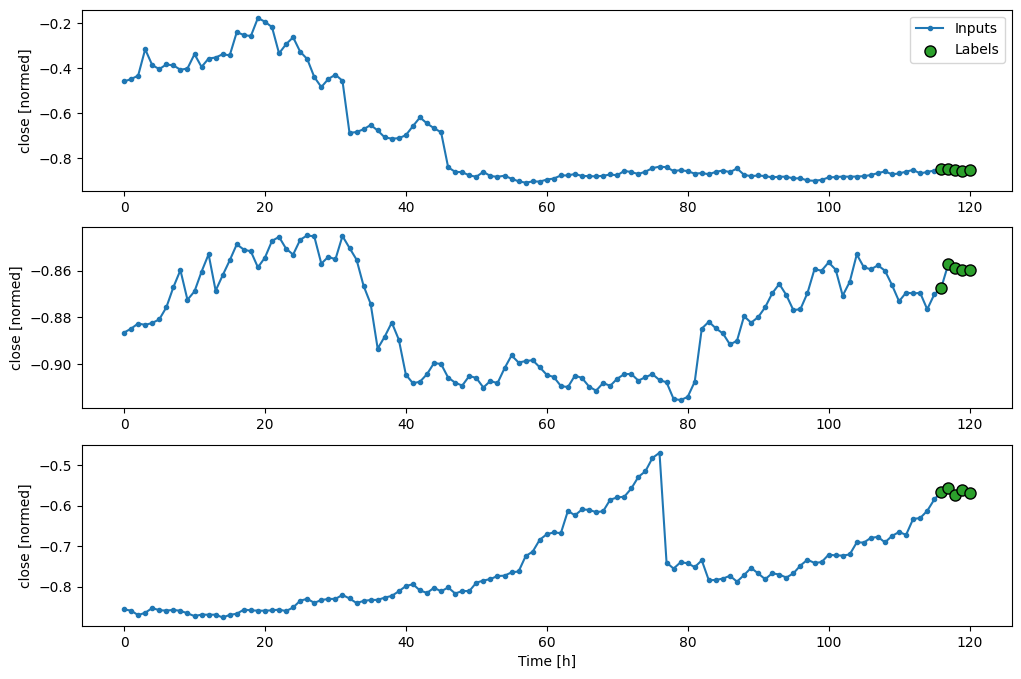

In [78]:
window.plot()